## Imports and preliminaries

In [188]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../src'))
import numpy as np
import matplotlib.pyplot as plt
import pdb

import recursiveLeastSquares
import splitConformalPrediction
from MultiValidPrediction import MultiValidPrediction
from calibrationScorers import residualCalibrationScorer, customResidualCalibrationScorer

In [189]:
# Define group that includes all points

def all_points(x):
    return True

basic_group = [all_points]
num_groups = len(basic_group)

## Synthetic Experiment - Comparing split-conformal prediction against MVP: Single Trial

##### Set all parameters for single trial

In [195]:
# Parameters for our uncertainty quantifier
T = 2000
n = 40
r = 800000
delta = 0.1
K_e = 2.12 

eta = np.sqrt(np.log(num_groups * n) / (2 * K_e * num_groups * n))

# Parameters for data generation
x_std = 0.1
y_std = 0.2
d = 300

##### Generating data defined by ordinary least-squares model 

In [210]:
theta = np.random.normal(loc=np.zeros(d), scale=x_std)

# Generating input-output pairs for T time-steps. Labels are defined by an ordinary least-squares model. 
xs_binvars = np.random.randint(low = 0, high = 2, size = (T, 10))
xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(T, d - 10))
xs = np.concatenate((xs_binvars, xs_remvars), axis = 1)
ys = np.dot(xs, theta) + np.random.normal(loc=0, scale=y_std, size=T)

##### Initializing uncertainty-quantifiers and small initial calibration set for split-conformal prediction 

In [211]:
myUncertaintyQuantifier = MultiValidPrediction(delta, n, basic_group, eta, r, normalize_by_counts=False)
myConformalPredictor = splitConformalPrediction.splitConformal(num_groups, basic_group, delta)

myRLS_conformal = recursiveLeastSquares.RLS(d, 1.0, 1)
myRLS_ours = recursiveLeastSquares.RLS(d, 1.0, 1)

mult_factor = 1
myResidualCalibrationScorer = customResidualCalibrationScorer.customResidualCalibrationScorer(mult_factor)

# arrays for MVP
q_array = []
y_pred_ours_array = []
covered_ours_array = []

# arrays for conformal prediction
y_pred_conformal_array = []
w_t_conformal_array = []
covered_conformal_array = []

init_size = 10
conformal_calibration_xs_binvars = np.random.randint(low = 0, high = 2, size = (init_size, 10))
conformal_calibration_xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(init_size, d - 10))
xs_cc = np.concatenate((conformal_calibration_xs_binvars, conformal_calibration_xs_remvars), axis = 1)
ys_cc = np.dot(xs_cc, theta) + np.random.normal(loc=0, scale=y_std, size=init_size)

for i, curr_y in enumerate(ys_cc):
    curr_x = xs_cc[i]
    myConformalPredictor.update_calibration_data(curr_x, curr_y)

##### Running MVP and split-conformal prediction across generated data

In [212]:
for t in range(T):
    x_t = xs[t]
    y_t = ys[t]

    # 1. SPLIT-CONFORMAL
    y_pred_conformal_t = myRLS_conformal.predict(x_t)
    myResidualCalibrationScorer.update(myRLS_conformal.predict)
    w_t_conformal = myConformalPredictor.select_best_width(myResidualCalibrationScorer, x_t)
    
    conformal_prediction_set = myResidualCalibrationScorer.get_prediction_set(x_t, w_t_conformal, mult_factor)

    covered_conformal_t = conformal_prediction_set.cover(y_t)
#   (1 if y_pred_conformal_t - w_t_conformal < y_t < y_pred_conformal_t + w_t_conformal else 0)

    # Adding new time-step data into either calibration data-set or to update model
    if t % 2 == 0:
        # Update the the calibration data set
        myConformalPredictor.update_calibration_data(x_t, y_t)  
    else:
        # update the linear regression model
        myRLS_conformal.add_obs(x_t.T, y_t)

    y_pred_conformal_array.append(y_pred_conformal_t)
    w_t_conformal_array.append(w_t_conformal)
    covered_conformal_array.append(covered_conformal_t)

    # 2. MVP
    y_pred_ours_t = myRLS_ours.predict(x_t)
    myResidualCalibrationScorer.update(myRLS_ours.predict)

    q_t = myUncertaintyQuantifier.predict(x_t)
    curr_prediction_set = myResidualCalibrationScorer.get_prediction_set(x_t, q_t, mult_factor)

    covered_ours_t = curr_prediction_set.cover(y_t)

    s_t = myResidualCalibrationScorer.calc_score(x_t, y_t)

    myRLS_ours.add_obs(x_t.T, y_t)
    myUncertaintyQuantifier.update(x_t, q_t, s_t)

    y_pred_ours_array.append(y_pred_ours_t)
    q_array.append(q_t)
    covered_ours_array.append(covered_ours_t)
print('Trial complete')

Trial complete


##### Overall statistics

In [213]:
y_pred_conformal_array = np.array(y_pred_conformal_array)
w_t_conformal_array = np.array(w_t_conformal_array)

y_pred_ours_array = np.array(y_pred_ours_array)
q_array = np.array(q_array)    

print("*** MARGINAL COVERAGE ***")
print("Split-conformal: {0}".format(np.average(covered_conformal_array)))
print("MVP: {0}".format(np.average(covered_ours_array)))
print("")

print("*** PREDICTION INTERVAL WIDTH *** ")
# Width of interval is twice the conformal-score value
print("Split-conformal: {0}".format(2 * np.average(w_t_conformal_array)))
print("MVP: {0}".format(2 * np.average(q_array)))
print("")

print("*** SQUARED LOSS ***")
squared_loss_conformal = np.linalg.norm(ys - y_pred_conformal_array)
squared_loss_ours = np.linalg.norm(ys - y_pred_ours_array)
print("Split-conformal: {0}".format(squared_loss_conformal))
print("MVP: {0}".format(squared_loss_ours))

*** MARGINAL COVERAGE ***
Split-conformal: 0.8945
MVP: 0.9

*** PREDICTION INTERVAL WIDTH *** 
Split-conformal: 0.8310368231492312
MVP: 0.7918499725000001

*** SQUARED LOSS ***
Split-conformal: 11.327922737128382
MVP: 10.728205404753648


##### Plots 

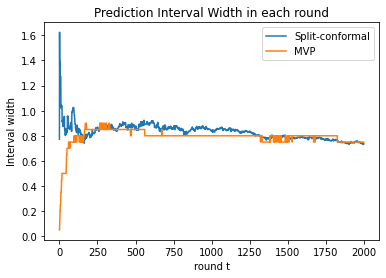

In [214]:
# Plotting the prediction interval width for both methods across all rounds

# Width of interval is twice the conformal-score value
plt.plot(range(T), 2 * w_t_conformal_array, label='Split-conformal')
plt.plot(range(T), 2 * q_array, label='MVP')


plt.legend(loc="upper right")
plt.xlabel("round t")
plt.ylabel("Interval width")
plt.title("Prediction Interval Width in each round")
plt.show()

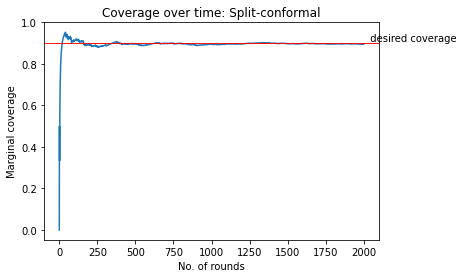

In [215]:
# Plotting marginal coverage over time for split-conformal

covered_conformal_over_time = [np.average(covered_conformal_array[:t+1]) for t in range(len(covered_conformal_array))]
plt.plot(range(T), covered_conformal_over_time)


plt.xlabel("No. of rounds")
plt.ylabel("Marginal coverage")
plt.axhline(y = 1 - delta, color = 'red', linestyle = '-', linewidth = 0.9)
plt.text(T, 1 - delta + 0.01, '  desired coverage')
plt.title("Coverage over time: Split-conformal")
plt.show()

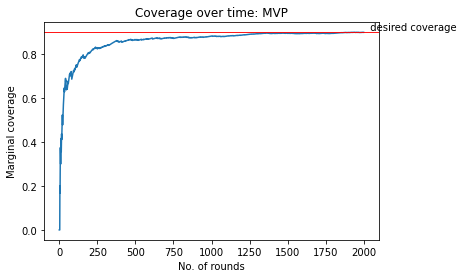

In [216]:
# Plotting marginal coverage across time for MVP

covered_our_over_time = [np.average(covered_ours_array[:t+1]) for t in range(len(covered_ours_array))]
plt.plot(range(T), covered_our_over_time)

plt.xlabel("No. of rounds")
plt.ylabel("Marginal coverage")
plt.axhline(y = 1 - delta, color = 'red', linestyle = '-', linewidth = 0.9)
plt.text(T, 1 - delta + 0.01, '  desired coverage')
plt.title("Coverage over time: MVP")
plt.show()

## Running several trials

##### Set all parameters and number of trials to run

In [179]:
# Parameters for our uncertainty quantifier
T = 2000
n = 40
r = 8000000
delta = 0.1
K_e = 2.12

def all_points(x):
    return True

basic_group = [all_points]
num_groups = len(basic_group)
eta = np.sqrt(np.log(num_groups * n) / (2 * K_e * num_groups * n))
keep_track_v_dict = True

# data generation - constants
x_std = 0.1
y_std = 0.2
d = 300 # choose d > 10
mult_factor = 2

# How many trials would you like to run?
num_rounds = 100

##### Start trials

In [183]:
coverage_conformal_per_round = np.zeros(num_rounds)
coverage_ours_per_round = np.zeros(num_rounds)
width_conformal_per_round = np.zeros(num_rounds)
width_ours_per_round = np.zeros(num_rounds)

for k in range(num_rounds):
    print('Running trial: ' + str(k))
    # data generation - random for each run

    theta = np.random.normal(loc=np.zeros(d), scale=x_std)

    # d-dimension features - first 10 features are binary
    xs_binvars = np.random.randint(low = 0, high = 2, size = (T, 10))
    xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(T, d - 10))
    xs = np.concatenate((xs_binvars, xs_remvars), axis = 1)
    # Elements of xs which are in an odd number of "positive" groups [value = 1] will have more noise
    ys = np.dot(xs, theta) + np.random.normal(loc=0, scale= y_std, size=T)
    
    # Defining all uncertainty quantifiers and regressors
    myUncertaintyQuantifier = MultiValidPrediction(delta, n, basic_group, eta, r, normalize_by_counts=False)
    myConformalPredictor = splitConformalPrediction.splitConformal(num_groups, groups, delta)
    myRLS_conformal = recursiveLeastSquares.RLS(d, 1.0, 1)
    myRLS_ours = recursiveLeastSquares.RLS(d, 1.0, 1)

    myResidualCalibrationScorer = customResidualCalibrationScorer.customResidualCalibrationScorer(mult_factor)

    # arrays for MVP
    q_array = []
    y_pred_ours_array = []
    covered_ours_array = []

    # arrays for conformal prediction
    y_pred_conformal_array = []
    w_t_conformal_array = []
    covered_conformal_array = []

    # Conformal warm-start calibration set using the same distribution. 
    init_size = 15
    conformal_calibration_xs_binvars = np.random.randint(low = 0, high = 2, size = (init_size, 10))
    conformal_calibration_xs_remvars = np.random.normal(loc=np.zeros(d - 10), scale=x_std, size=(init_size, d - 10))
    xs_cc = np.concatenate((conformal_calibration_xs_binvars, conformal_calibration_xs_remvars), axis = 1)
    ys_cc = np.dot(xs_cc, theta) + np.random.normal(loc=0, scale= y_std, size=init_size)

    for i, curr_y in enumerate(ys_cc):
        curr_x = xs_cc[i]
        myConformalPredictor.update_calibration_data(curr_x, curr_y)
    
    # Run algorithms
    
    for t in range(T):
        x_t = xs[t]
        y_t = ys[t]

        # 1. CONFORMAL PREDICTION

        y_pred_conformal_t = myRLS_conformal.predict(x_t)
        myResidualCalibrationScorer.update(myRLS_conformal.predict)

        w_t_conformal = myConformalPredictor.select_best_width(myResidualCalibrationScorer, x_t)
        conformal_prediction_set = myResidualCalibrationScorer.get_prediction_set(x_t, w_t_conformal, mult_factor)

        covered_conformal_t = conformal_prediction_set.cover(y_t)

        if t % 2 == 0:
            myConformalPredictor.update_calibration_data(x_t, y_t)
        else:
            # update the linear regression model
            myRLS_conformal.add_obs(x_t, y_t)

        y_pred_conformal_array.append(y_pred_conformal_t)
        w_t_conformal_array.append(mult_factor * w_t_conformal)
        covered_conformal_array.append(covered_conformal_t)

        # 2. MVP
        y_pred_ours_t = myRLS_ours.predict(x_t)
        myResidualCalibrationScorer.update(myRLS_ours.predict)

        q_t = myUncertaintyQuantifier.predict(x_t)
        curr_prediction_set = myResidualCalibrationScorer.get_prediction_set(x_t, q_t, mult_factor)

        covered_ours_t = curr_prediction_set.cover(y_t)

        s_t = myResidualCalibrationScorer.calc_score(x_t, y_t)

        myRLS_ours.add_obs(x_t.T, y_t)
        myUncertaintyQuantifier.update(x_t, q_t, s_t)

        y_pred_ours_array.append(y_pred_ours_t)
        q_array.append(mult_factor * q_t)
        covered_ours_array.append(covered_ours_t)
    
    y_pred_conformal_array = np.array(y_pred_conformal_array)
    w_t_conformal_array = np.array(w_t_conformal_array)

    y_pred_ours_array = np.array(y_pred_ours_array)
    q_array = np.array(q_array)
    
    coverage_conformal_per_round[k] = np.average(covered_conformal_array)
    coverage_ours_per_round[k] = np.average(covered_ours_array)
    
    # Interval width is twice the chosen conformal score
    width_conformal_per_round[k] = 2 * np.average(w_t_conformal_array)
    width_ours_per_round[k] = 2 * np.average(q_array)
    
print('All trials complete')    

Running trial: 0
Running trial: 1
Running trial: 2
Running trial: 3
Running trial: 4
Running trial: 5
Running trial: 6
Running trial: 7
Running trial: 8
Running trial: 9
Running trial: 10
Running trial: 11
Running trial: 12
Running trial: 13
Running trial: 14
Running trial: 15
Running trial: 16
Running trial: 17
Running trial: 18
Running trial: 19
Running trial: 20
Running trial: 21
Running trial: 22
Running trial: 23
Running trial: 24
Running trial: 25
Running trial: 26
Running trial: 27
Running trial: 28
Running trial: 29
Running trial: 30
Running trial: 31
Running trial: 32
Running trial: 33
Running trial: 34
Running trial: 35
Running trial: 36
Running trial: 37
Running trial: 38
Running trial: 39
Running trial: 40
Running trial: 41
Running trial: 42
Running trial: 43
Running trial: 44
Running trial: 45
Running trial: 46
Running trial: 47
Running trial: 48
Running trial: 49
Running trial: 50
Running trial: 51
Running trial: 52
Running trial: 53
Running trial: 54
Running trial: 55
Ru

##### Histograms of marginal coverage and interval width across trials

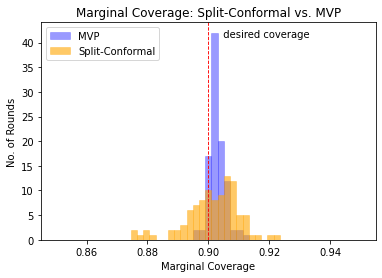

In [186]:
# Plot histogram of marginal coverage for both methods across all trials

# Set bins as desired
bins = np.linspace(1 - delta - 0.05, 1 - delta + 0.05, 50)
y_ours, _,  _ = plt.hist(coverage_ours_per_round, bins = bins, color = 'blue', alpha = 0.4, label = 'MVP', edgecolor = 'blue', linewidth = 0.5)
y_conformal, _, _ = plt.hist(coverage_conformal_per_round, bins = bins, color = 'orange', alpha = 0.6, label = 'Split-Conformal', edgecolor = 'orange', linewidth = 0.5)
max_y_ours = max(y_ours)
max_y_conformal = max(y_conformal)
y_max = max(max_y_ours, max_y_conformal)

plt.axvline(x = 1 - delta, color = 'red', linestyle = '--', linewidth = 0.9)
plt.text(1 - delta + 0.003, y_max - 1, '  desired coverage')
plt.xlabel('Marginal Coverage')
plt.ylabel('No. of Rounds')
plt.legend(loc="upper left")
plt.title('Marginal Coverage: Split-Conformal vs. MVP')
# plt.savefig('marginal-coverage.pdf')
plt.show()

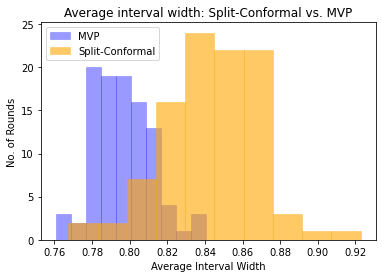

In [187]:
# Plot histogram of prediction interval width for both methods across all trials

# Set bins as desired
# bins = np.linspace(1 - delta - 0.4, 1 - delta + 0.4, 50)

plt.hist(width_ours_per_round, color = 'blue', alpha = 0.4, label = 'MVP', edgecolor = 'blue', linewidth = 0.5)
plt.hist(width_conformal_per_round,  color = 'orange', alpha = 0.6, label = 'Split-Conformal', edgecolor = 'orange', linewidth = 0.5)
plt.xlabel('Average Interval Width')
plt.ylabel('No. of Rounds')
plt.legend()
plt.title('Average interval width: Split-Conformal vs. MVP')
# plt.savefig('average-interval-width.pdf')
plt.show()